In [18]:
import math
import numpy as np
import pandas as pd
from timeseriesutils import featurize

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('demo_data.csv')[['location', 'date', 'inc_hosp', 'population', 'rate']]
data.date = pd.to_datetime(data.date)
data

,location,date,inc_hosp,population,rate
0,AK,2020-10-01,3.0,731545,0.410091
1,AK,2020-10-02,7.0,731545,0.956879
2,AK,2020-10-03,5.0,731545,0.683485
3,AK,2020-10-04,5.0,731545,0.683485
4,AK,2020-10-05,1.0,731545,0.136697
...,...,...,...,...,...
13969,WY,2021-06-27,10.0,578759,1.727835
13970,WY,2021-06-28,9.0,578759,1.555051
13971,WY,2021-06-29,7.0,578759,1.209484
13972,WY,2021-06-30,8.0,578759,1.382268


In [130]:
import importlib
featurize = importlib.reload(featurize)

# Taylor polynomial coefficients in a rolling window

The function `featurize.windowed_taylor_coefs` estimates the coefficients of a Taylor polynomial approximation to the data in a rolling window. These coefficients can be interpreted as estimates of the derivatives of an underlying smooth function based on noisy observations. The window can be `centered` at the time t, which may yield more stable estimates, but has the limitation that the treatment is inconsistent for different windows. In particular, there is not a full set of observed data in the windows at the beginning and end of the time series; in those windows, we fit to the available data. Alternatively, the window may be  `trailing` relative to the time t.

To start, we illustrate fitting a degree 1 Taylor polynomial (i.e, a line) in centered windows of size 21 for the data from California. These are the default settings.

In [123]:
ca_data = data[data.location == 'CA']
ca_data_w_deg1 = featurize.windowed_taylor_coefs_one_grp(ca_data, target_var='rate', fill_edges=True)
ca_data_w_deg1

,location,date,inc_hosp,population,rate,rate_taylor_0,rate_taylor_1
1096,CA,2020-10-01,316.0,39512223,0.799753,0.819769,0.000368
1097,CA,2020-10-02,328.0,39512223,0.830123,0.817982,0.001292
1098,CA,2020-10-03,294.0,39512223,0.744074,0.814103,0.004394
1099,CA,2020-10-04,315.0,39512223,0.797222,0.819782,0.003109
1100,CA,2020-10-05,347.0,39512223,0.878209,0.822901,0.003082
...,...,...,...,...,...,...,...
1365,CA,2021-06-27,162.0,39512223,0.410000,0.431006,0.011389
1366,CA,2021-06-28,201.0,39512223,0.508703,0.444475,0.012949
1367,CA,2021-06-29,199.0,39512223,0.503642,0.455778,0.012126
1368,CA,2021-06-30,165.0,39512223,0.417592,0.465702,0.011300


In [131]:
temp = featurize.featurize_data(ca_data, target_var='rate', group_vars=None,
                         features = [{
                           'fun': 'windowed_taylor_coefs',
                           'args': {
                             'target_var': 'rate'
                           }
                         }])
temp[0]

,location,date,inc_hosp,population,rate,rate_taylor_0,rate_taylor_1
1096,CA,2020-10-01,316.0,39512223,0.799753,0.819769,0.000368
1097,CA,2020-10-02,328.0,39512223,0.830123,0.817982,0.001292
1098,CA,2020-10-03,294.0,39512223,0.744074,0.814103,0.004394
1099,CA,2020-10-04,315.0,39512223,0.797222,0.819782,0.003109
1100,CA,2020-10-05,347.0,39512223,0.878209,0.822901,0.003082
...,...,...,...,...,...,...,...
1365,CA,2021-06-27,162.0,39512223,0.410000,0.431006,0.011389
1366,CA,2021-06-28,201.0,39512223,0.508703,0.444475,0.012949
1367,CA,2021-06-29,199.0,39512223,0.503642,0.455778,0.012126
1368,CA,2021-06-30,165.0,39512223,0.417592,0.465702,0.011300


This augmented the data frame with the new columns `rate_taylor_0` and `rate_taylor_1` containing the estimated Taylor coefficients at each time point. We plot the estimated lines at a few representative times below:

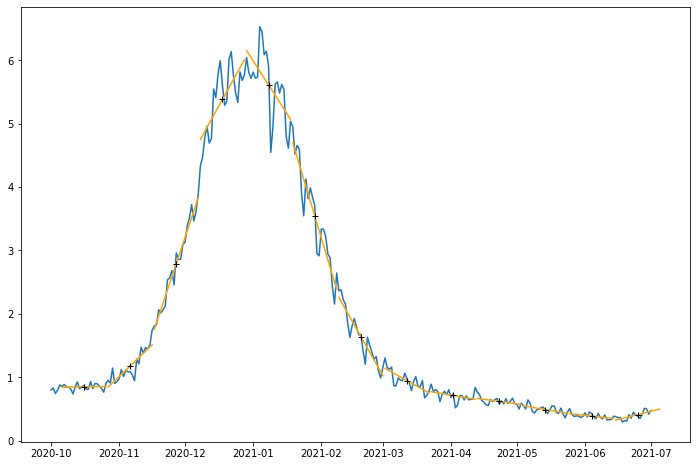

In [36]:
def plot_taylor_fits(data, taylor_degree, window_size, window_align = 'centered'):
    '''
    Helper function to plot Taylor polynomial fits.
    '''
    plt.figure(figsize = (12,8))
    plt.plot(data.date, data.rate)
    
    if window_align == 'centered':
        half_window = (window_size - 1) // 2
        window_lags = np.arange(-half_window, half_window + 1)
    elif window_align == 'trailing':
        window_lags = np.arange(-window_size, 0) + 1
    
    taylor_basis = np.concatenate(
        [np.ones((window_size, 1))] + \
            [np.expand_dims((1 / math.factorial(d)) * window_lags**d, -1) \
                for d in range(1, taylor_degree + 1)],
        axis = 1
    )
    
    for center_ind in np.arange(15, data.shape[0], 21):
        center_date = data.loc[data.index[center_ind], 'date']
        segment_dates = [center_date + pd.Timedelta(l, unit='days') for l in window_lags]
        coef_names = ['rate_taylor_' + str(d) for d in range(taylor_degree + 1)]
        taylor_coefs = data.loc[data.index[center_ind], coef_names].values
        taylor_coefs = np.expand_dims(taylor_coefs, -1)
        y_hat = np.matmul(taylor_basis, taylor_coefs)
        plt.plot(segment_dates, y_hat, color = 'orange')
        plt.plot(center_date, taylor_coefs[0,0], '+', color='black')

plot_taylor_fits(ca_data_w_deg1, taylor_degree=1, window_size=21, window_align='centered')

We can also repeat the above using degree 2 Taylor polynomial approximations, i.e., parabolas.

In [34]:
ca_data_w_deg2 = featurize.windowed_taylor_coefs(ca_data, target_var='rate', taylor_degree=2)
ca_data_w_deg2

,location,date,inc_hosp,population,rate,rate_taylor_0,rate_taylor_1,rate_taylor_2
1096,CA,2020-10-01,316.0,39512223,0.799753,0.767382,0.035293,-0.006985
1097,CA,2020-10-02,328.0,39512223,0.830123,0.802022,0.018529,-0.003830
1098,CA,2020-10-03,294.0,39512223,0.744074,0.813618,0.006336,-0.000485
1099,CA,2020-10-04,315.0,39512223,0.797222,0.822056,0.007088,-0.001137
1100,CA,2020-10-05,347.0,39512223,0.878209,0.826856,0.005537,-0.000818
...,...,...,...,...,...,...,...,...
1365,CA,2021-06-27,162.0,39512223,0.410000,0.430377,0.011779,0.000130
1366,CA,2021-06-28,201.0,39512223,0.508703,0.446707,0.009043,-0.001116
1367,CA,2021-06-29,199.0,39512223,0.503642,0.454903,0.008627,-0.000875
1368,CA,2021-06-30,165.0,39512223,0.417592,0.463674,0.009110,-0.000487


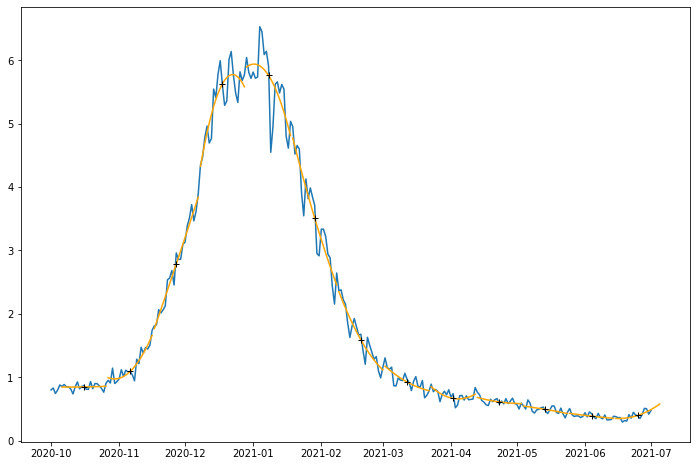

In [37]:
plot_taylor_fits(ca_data_w_deg2, taylor_degree=2, window_size=21, window_align='centered')

We can interpret the Taylor polynomial coefficient estimates at each time as estimates of the level, slope, and curvature of the signal at that time.

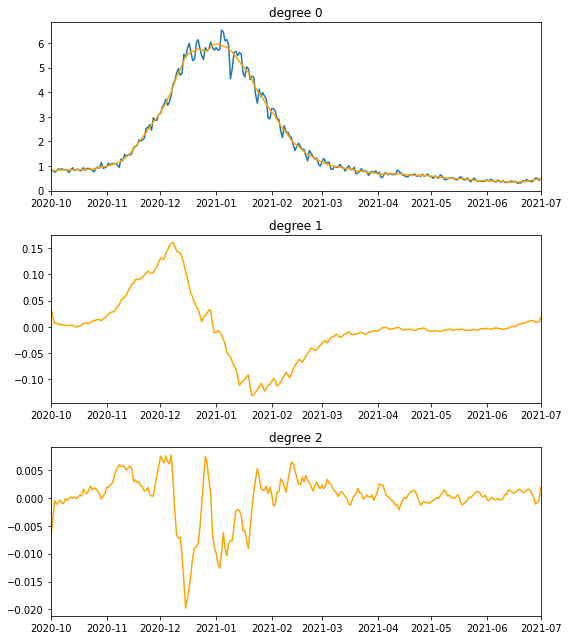

In [100]:
def stacked_taylor_coef_plot(data, taylor_degree):
    fig, ax = plt.subplots(taylor_degree + 1, 1, figsize=(8, 3 * (taylor_degree + 1)))
    
    for d in range(taylor_degree + 1):
        if d == 0:
            ax[d].plot(data.date, data.rate)
        
        ax[d].plot(data.date, data[f'rate_taylor_{d}'], color = 'orange')
        ax[d].set_xlim(np.min(data.date), np.max(data.date))
        ax[d].set(title=f'degree {d}')
    
    plt.tight_layout()
    plt.show()

stacked_taylor_coef_plot(data=ca_data_w_deg2, taylor_degree=2)

We can obtain smoother estimates if we use a longer window size, and in general higher-degree polynomials require longer window sizes.

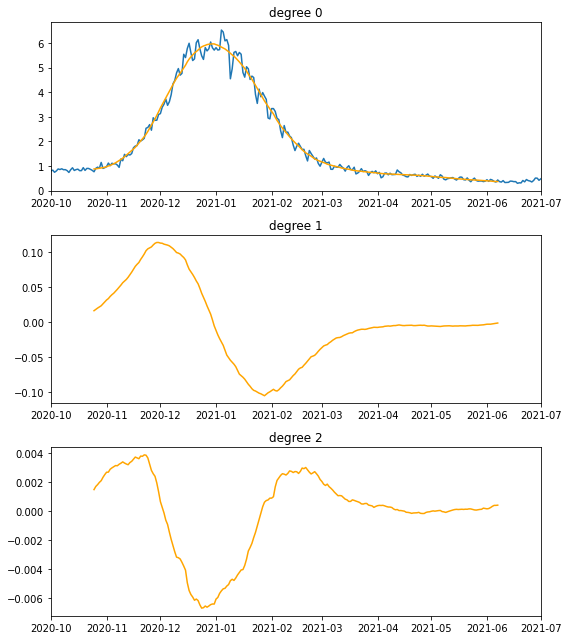

In [101]:
ca_data_w_deg2_window_49 = featurize.windowed_taylor_coefs(ca_data, target_var='rate', taylor_degree=2, window_size=49)
stacked_taylor_coef_plot(data=ca_data_w_deg2_window_49, taylor_degree=2)


If the Taylor coefficients are being used as summaries of the data in the context of a forecasting model, it can be helpful to use trailing windows. This ensures that the treatment of the data at the end of the series, which will be most directly used for forecasting, matches the treatment of the data in previous windows. However, the use of trailing windows can impact the reliability of trend estimates since a polynomial will tend to fit the center of the data window better than the edges. We illustrate this below:

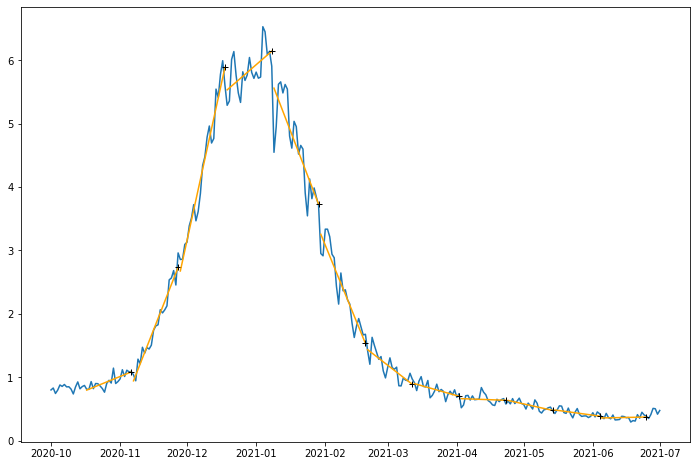

In [102]:
ca_data_w_deg1_trailing = featurize.windowed_taylor_coefs(ca_data, target_var='rate', window_align='trailing')
plot_taylor_fits(ca_data_w_deg1_trailing, taylor_degree=1, window_size=21, window_align='trailing')

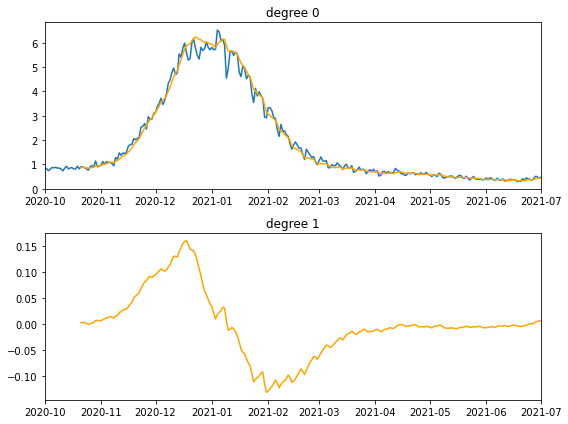

In [103]:
stacked_taylor_coef_plot(data=ca_data_w_deg1_trailing, taylor_degree=1)

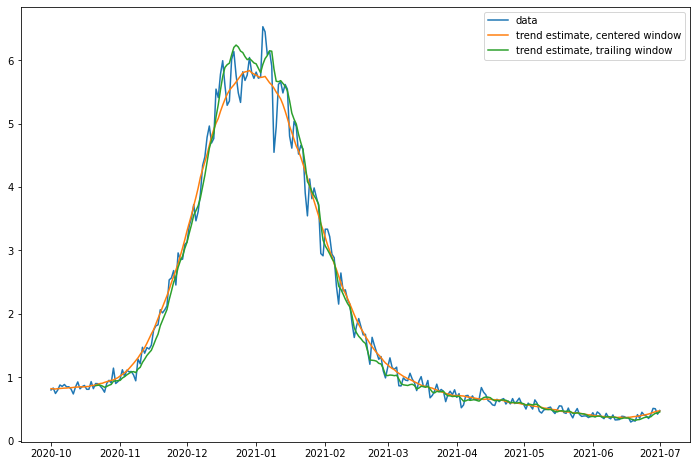

In [104]:
plt.figure(figsize = (12,8))
plt.plot(ca_data.date, ca_data.rate, label='data')
plt.plot(ca_data_w_deg1.date,
         ca_data_w_deg1.rate_taylor_0,
         label='trend estimate, centered window')
plt.plot(ca_data_w_deg1_trailing.date,
         ca_data_w_deg1_trailing.rate_taylor_0,
         label='trend estimate, trailing window')
plt.legend()

The behavior of a degree 2 polynomial with a larger window size is qualitatively similar:

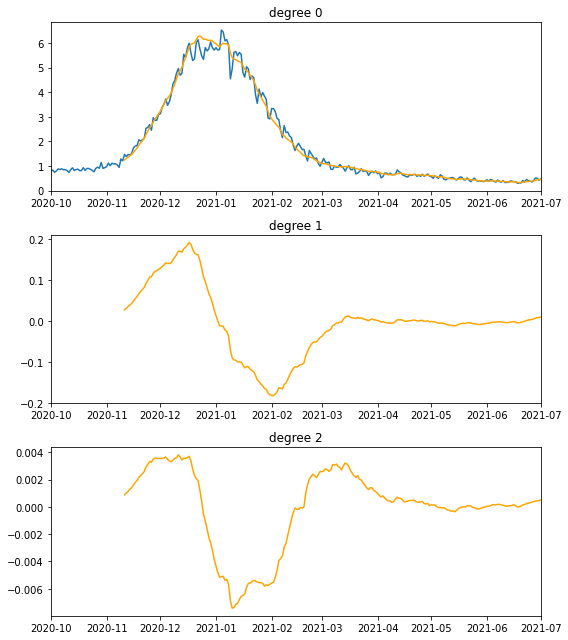

In [107]:
ca_data_w_deg2_trailing = featurize.windowed_taylor_coefs(ca_data, target_var='rate', taylor_degree=2, window_align='trailing', window_size=42)
stacked_taylor_coef_plot(data=ca_data_w_deg2_trailing, taylor_degree=2)

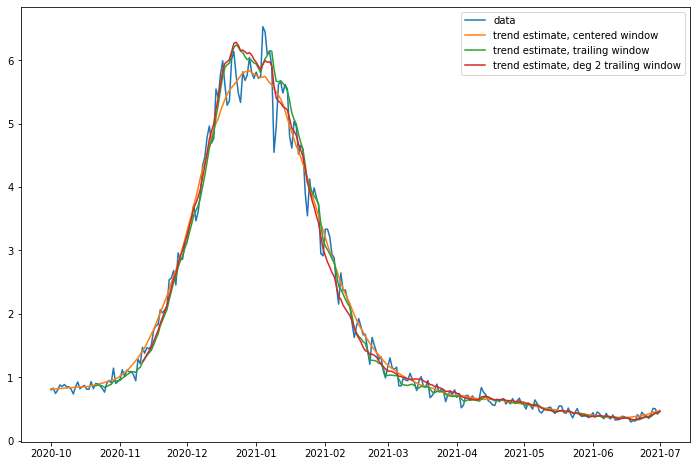

In [108]:
plt.figure(figsize = (12,8))
plt.plot(ca_data.date, ca_data.rate, label='data')
plt.plot(ca_data_w_deg1.date,
         ca_data_w_deg1.rate_taylor_0,
         label='trend estimate, centered window')
plt.plot(ca_data_w_deg1_trailing.date,
         ca_data_w_deg1_trailing.rate_taylor_0,
         label='trend estimate, trailing window')
plt.plot(ca_data_w_deg2_trailing.date,
         ca_data_w_deg2_trailing.rate_taylor_0,
         label='trend estimate, deg 2 trailing window')
plt.legend()

We can use the `featurize_data` function to perform these calculations simultaneously for all locations and compare to a simple 7 day rolling mean:

In [174]:
import importlib
featurize = importlib.reload(featurize)

In [187]:
all_data_w_taylor_deg1, _, _ = featurize.featurize_data(
    data, target_var='rate', group_vars=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'target_var': 'rate',
                'group_vars': ['location'],
                'taylor_degree': 2,
                # 'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': 42,
                # 'window_size': 29,
                'fill_edges': False
            }
        },
        {
            'fun': 'rolling_mean',
            'args': {
                'target_var': 'rate',
                'group_vars': ['location'],
                'window_size': 7
            }
        },
        {
            'fun': 'lagged_values',
            'args': {
                'target_var': 'rate_roll_mean_7',
                'group_vars': ['location'],
                'lags': [7]
            }
        }
    ])

all_data_w_taylor_deg1['empirical_deriv'] = (all_data_w_taylor_deg1['rate_roll_mean_7'] - all_data_w_taylor_deg1['rate_roll_mean_7_lag_7']) / 7
all_data_w_taylor_deg1

,location,date,inc_hosp,population,rate,rate_taylor_0,rate_taylor_1,rate_taylor_2,rate_roll_mean_7,rate_roll_mean_7_lag_7,empirical_deriv
0,AK,2020-10-01,3.0,731545,0.410091,NaN,NaN,NaN,NaN,NaN,NaN
1,AK,2020-10-02,7.0,731545,0.956879,NaN,NaN,NaN,NaN,NaN,NaN
2,AK,2020-10-03,5.0,731545,0.683485,NaN,NaN,NaN,NaN,NaN,NaN
3,AK,2020-10-04,5.0,731545,0.683485,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,2020-10-05,1.0,731545,0.136697,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13969,WY,2021-06-27,10.0,578759,1.727835,0.949448,-0.052961,-0.001925,1.209484,1.086068,0.017631
13970,WY,2021-06-28,9.0,578759,1.555051,1.069838,-0.033304,-0.000871,1.357585,0.888601,0.066998
13971,WY,2021-06-29,7.0,578759,1.209484,1.092878,-0.026297,-0.000460,1.431635,0.839234,0.084629
13972,WY,2021-06-30,8.0,578759,1.382268,1.144384,-0.017518,-0.000021,1.530368,0.765184,0.109312


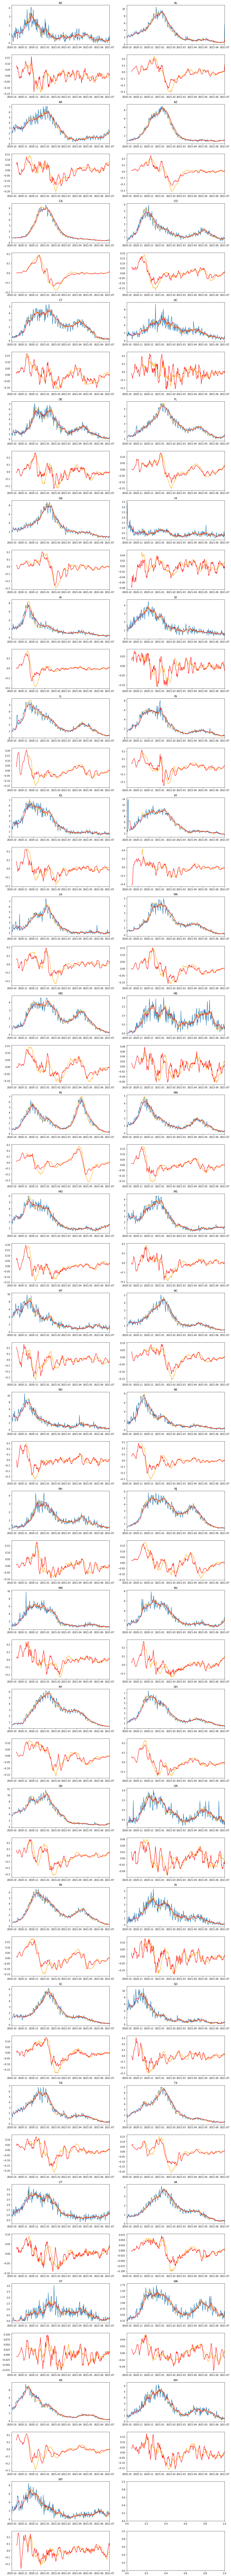

In [188]:
locations = all_data_w_taylor_deg1.location.unique()
fig_ncol = 2
fig_nrow = math.ceil(len(locations) / fig_ncol) * 2
fig, ax = plt.subplots(fig_nrow, fig_ncol, figsize=(14, 3 * fig_nrow))

for i, loc in enumerate(locations):
    row_ind = (i // fig_ncol) * 2
    col_ind = i % fig_ncol
    loc_data = all_data_w_taylor_deg1[all_data_w_taylor_deg1.location == loc]
    ax[row_ind, col_ind].plot(loc_data.date, loc_data.rate)
    ax[row_ind, col_ind].plot(loc_data.date, loc_data.rate_taylor_0, color = "orange")
    ax[row_ind, col_ind].plot(loc_data.date, loc_data.rate_roll_mean_7, color = "red")
    
    ax[row_ind + 1, col_ind].plot(loc_data.date, loc_data.rate_taylor_1, color = "orange")
    ax[row_ind + 1, col_ind].plot(loc_data.date, loc_data.empirical_deriv, color = "red")
    ax[row_ind, col_ind].set_xlim(np.min(loc_data.date), np.max(loc_data.date))
    ax[row_ind + 1, col_ind].set_xlim(np.min(loc_data.date), np.max(loc_data.date))
    ax[row_ind, col_ind].set(title=loc)

plt.tight_layout()
plt.show()